# Lab 9: Nonparametric methods

Welcome to the ninth DS102 lab! 

The goal of this lab is to explore and interpret several nonparametric methods for regression.

The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.

In preparation for this lab we would recommend that you review the notes from Lectures 20 and 21.

## Collaboration Policy {-}

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission {-}

To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Sunday, April 11, 2021 at 11:59 PM. PST**

## Collaborators {-}
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

sns.set()

import hashlib
def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

# 1. Model comparison

In this lab, we'll be working with the hybrid car dataset ([which you may remember from Data 8](https://inferentialthinking.com/chapters/15/1/Correlation.html)).

It contains data on 153 different models of hybrid car from 1997 to 2013, with the price (`msrp`), gas mileage (`mpg`), type of car (`class`), and how fast the car accelerates in km/hour/second (`acceleration`).

We're going to try to predict the price using other features of the car.

In [2]:
hybrid = pd.read_csv('hybrid.csv')

X_cols = ["year", "acceleration", "mpg"] # Columns used for prediction
y_col = "msrp" # The column we're trying to predict

hybrid

,vehicle,year,msrp,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
3,Insight,2000,18936.41,9.52,53.00,Two Seater
4,Civic (1st Gen),2001,25833.38,7.04,47.04,Compact
...,...,...,...,...,...,...
148,S400,2013,92350.00,13.89,21.00,Large
149,Prius Plug-in,2013,32000.00,9.17,50.00,Midsize
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize


This cell generates all pairs of scatterplots for numerical variables in the data. You should see the same trends discussed in the chapter of the Data 8 textbook linked above.

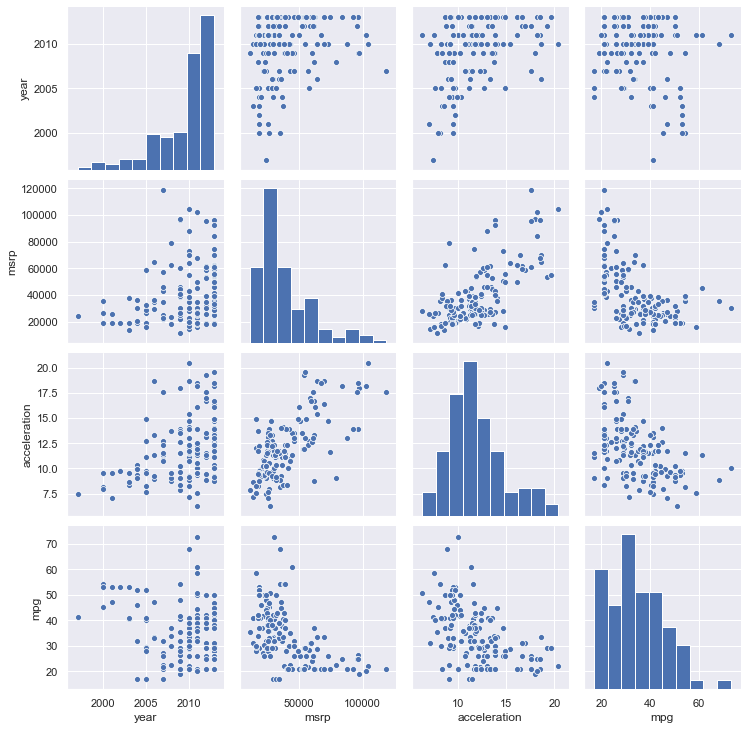

In [3]:
sns.pairplot(hybrid)

### 1(a) Splitting the data

We'll start by splitting the data into training and test sets. Use the scikit-learn function `train_test_split` to make two dataframes called `train` and `test`. The test set should have $30\%$ of the data (46 rows).

The `train_test_split` function has an argument that lets you ensure that it uses the same random split every time: you should set that argument to `102` to pass the tests.

In [4]:
# TODO: fill in


train, test = ..., ... # TODO: fill in

In [5]:
## SOLUTION
from sklearn.model_selection import train_test_split

# TODO: fill in
train, test = train_test_split(hybrid, test_size=0.3, random_state=102)

In [6]:
# Validation Test
assert(get_hash(train) == 'a8821bb31a8ae0d2b7803004be63656d')
assert(get_hash(test) == '96dbf091169d3503cd962bbba32db3f3')
print("Test passed!")

Test passed!


### 1(b) Predicting the output

#### 1.b.(i) Linear regression

Use linear regression to predict the MSRP from year, acceleration, and MPG. Add a new column to the `train` and `test` dataframes called `linear_pred` with the predictions from linear regression.

*Hint: throughout this lab, you should use the default values of all parameters for all models we're experimenting with.*

*Hint: for this lab, you don't need to worry about pandas warnings about setting a value on a copy of a slice.*

In [7]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
X = ... # TODO: fill in
y = ... # TODO: fill in
... # TODO: fill in

train["linear_pred"] = ... # TODO: fill in
test["linear_pred"] = ... # TODO: fill in

In [8]:
### SOLUTION
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
X = train.loc[:, X_cols] # TODO: fill in
y = train.loc[:, y_col] # TODO: fill in
linear_model.fit(X, y) # TODO: fill in

train["linear_pred"] = linear_model.predict(train.loc[:, X_cols]) # TODO: fill in
test["linear_pred"] = linear_model.predict(test.loc[:, X_cols]) # TODO: fill in

In [9]:
# Validation Test
assert(get_hash(train["linear_pred"]) == '42969b6301fad9e5e98680924754e9d6')
assert(get_hash(test["linear_pred"]) == '104e14d773c8efc0099711f9e62f0123')
assert(isinstance(linear_model, LinearRegression))
print("Test passed!")

Test passed!


Run the following cell that computes the training set error and test set error.

In [10]:
train_rmse = np.mean((train["linear_pred"] - train["msrp"]) ** 2) ** 0.5
test_rmse = np.mean((test["linear_pred"] - test["msrp"]) ** 2) ** 0.5

print("Training set error for linear model:", train_rmse)
print("Test set error for linear model:    ", test_rmse)

Training set error for linear model: 15139.208226548897
Test set error for linear model:     13521.818567754546


#### 1.b.(ii) Decision Trees

Recall that a decision tree is a method for classification and regression that uses a tree-like structure to decide what value to predict for a point.


In this question, we'll use a decision tree for regression instead of classification. When we built a decision tree for classification in lecture, we made decisions about splitting based on how homogeneous the $y$-values were. Now, we'll instead make splits based on the residuals for predicting at that node. 

Let's look at an example, assuming we're using mean squared error as our loss. For example, if we make our first split based on whether or not `mpg <= M`, we'll have some average MSRP for the low-MPG cars (below `M`), along with residuals if we used that average to predict the MSRP for all the low-MPG cars. Similarly, we have the same information for the high-MPG cars (above `M`). A good value of `M` will make the mean squared residuals for the two groups as small as possible. So, at each node, we choose a split that makes the mean squared error on each side as small as possible.

Compute the prediction from a decision tree with the default parameters for scikit-learn's `DecisionTreeRegressor` (i.e., no limit on tree depth). Add a new column to the `train` and `test` dataframes called `tree_pred` with the predictions from the decision tree.

*Hint: your code should look very similar to your answer from 1.b.(i).*

In [11]:
... # TODO: fill in import statement

tree_model = ... # TODO: fill in
... # TODO: fill in

train["tree_pred"] = ... # TODO: fill in
test["tree_pred"] = ... # TODO: fill in

In [12]:
### SOLUTION
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
X = train.loc[:, X_cols] # TODO: fill in
y = train.loc[:, y_col] # TODO: fill in
tree_model.fit(X, y) # TODO: fill in

train["tree_pred"] = tree_model.predict(train.loc[:, X_cols]) # TODO: fill in
test["tree_pred"] = tree_model.predict(test.loc[:, X_cols]) # TODO: fill in

In [13]:
# Validation Test
assert(get_hash(train["tree_pred"]) == 'dbcb9fedf8018825bf704351b0cd7f9d')
assert(isinstance(tree_model, DecisionTreeRegressor))
print("Test passed!")

Test passed!


Run the following cell that computes the training set error and test set error.

In [14]:
train_rmse = np.mean((train["tree_pred"] - train["msrp"]) ** 2) ** 0.5
test_rmse = np.mean((test["tree_pred"] - test["msrp"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 393.0619080391814
Test set error for decision tree:     16404.724233026926


#### 1.b.(iii) Random Forest

Recall that a random forest is the combination of a large number of decision trees.

Compute the prediction from a decision tree using scikit-learn's `RandomForestRegressor`, with the following parameters:
* 100 trees (default)
* no limit on each tree's depth (default)
* Use the `max_features` parameter to only use one feature for each tree. (*The recommended value for random forests is for each tree to only use 1/3 of the features, and in this case we have 3 features.*)

Add a new column to the `train` and `test` dataframes called `forest_pred` with the predictions from the random forest.

*Hint: your code should look very similar to your answers from 1.b.(i) and 1.b.(ii).*

In [15]:
### SOLUTION
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(max_features=1)
X = train.loc[:, X_cols] # TODO: fill in
y = train.loc[:, y_col] # TODO: fill in
forest_model.fit(X, y) # TODO: fill in

train["forest_pred"] = forest_model.predict(train.loc[:, X_cols]) # TODO: fill in
test["forest_pred"] = forest_model.predict(test.loc[:, X_cols]) # TODO: fill in

In [16]:
# Validation Test: If you aren't passing these, your random forest is doing something wrong
assert((((train["forest_pred"] - train["msrp"]) **2).sum()) < 3981470000.0)
assert((((test["forest_pred"] - test["msrp"]) **2).sum()) < 8015040000.0)
assert(isinstance(forest_model, RandomForestRegressor))
assert(forest_model.max_features != 'auto')
print("Test passed!")

Test passed!


Run the following cell that computes the training set error and test set error.

In [17]:
train_rmse = np.mean((train["forest_pred"] - train["msrp"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["msrp"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 5421.348316058797
Test set error for random forest:     12320.068807150044


### 1(c) accuracy comparison

Which model does best on the training set? Why? Which model does best on the test set? Why?

`# TODO: fill in`

Decision Tree does best on the training set while Random Forest does best on the test set. This makes intuitive sense because Decision Trees want to reduce the error based on the training data as much as possible (and would then overfit and would not generalize as well to the test data) while Random Forests, as the combination of many decision trees, limits overfitting, making it more generalizable to the test data while still limiting error.

### 1.d Interpretability

#### 1.d.i Linear Regression

Let's look at the coefficients from the linear regression model:

In [18]:
# You can just run this cell to print out the coefficients for each feature:
print(X_cols)
linear_model.coef_

['year', 'acceleration', 'mpg']


array([-255.24645465, 4260.68613645, -458.41724788])

Using this result, fill in the blanks in the following two statements:

"Each year, linear regression predicts that the average price changes by $\$ \rule{1cm}{0.15mm}$ ". (Your answer should be a positive or negative number)

"Linear regression predicts that cars with better gas mileage are $\rule{1cm}{0.15mm}$ expensive." (Your answer should be either 'more' or 'less')

`# TODO: fill in`

`### SOLUTION`

-$255.25

less

#### 1.d.ii Decision trees

We'll use the `plot_tree` function to draw the decision tree:

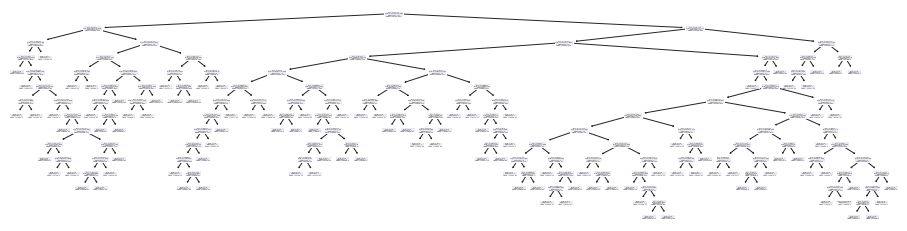

In [19]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 4))
plot_tree(tree_model);

We can see that the tree is quite deep and complex. Let's take a closer look at the nodes at the top:

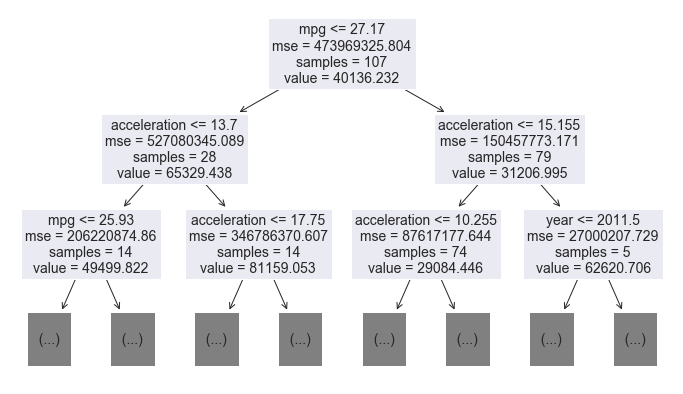

In [20]:
plt.figure(figsize=(12, 7))
plot_tree(tree_model, max_depth=2, fontsize=14, feature_names=X_cols);

There are a few things we can see right away:


* The first line tells us which feature to split on: values below the threshold go to the left, and values above go to the right.
* The third line tells us the number of training samples that made it that far into the tree.
* The fourth line tells us the average $y$-value (in this case, MSRP) of all the training samples that made it that far into the tree.


Just by looking at the first few layers, we can already see that the decision tree has pulled out the most expensive cars into some of the branches, and the less expensive ones into other branches.

Suppose we had stopped growing the tree at this point. That would have given us four leaf nodes, each with very different mean MSRP. Describe the node that contains the most expensive cars in plain English.

`# TODO: FILL IN`


The node containing the most expensive cars have a total of 14 cars all with an acceleration of less than 17.75 km/hour/sec and with an average price of $81159.05. 

#### Random Forests

Unfortunately, random forests are much harder to interpret than either of the other two methods that we've tried. In this case, with so few features, we might be able to look at the top of each tree and find similarities across most or all of the trees, but in high-dimensional problems, each tree should see a very different subset of features, and this becomes much harder.

# 2. Explanations

Many methods for explainable ML use the following setup to explain a specific prediction from a complex model:

1. Construct a simpler, easier-to-explain model (e.g., linear regression, decision tree, etc.) that behaves similarly to the complex model for data points near the specific point we're trying to explain.
2. Interpret the simpler model.

In this question, we'll try to see if we can come up with an explanation for the worst predictions from each model.

### 2.a Linear Regression

#### 2.a.i Finding the worst predictions

Find the two cars in the test set where linear regression does the worst (i.e., has the highest absolute error). Your answer should be a dataframe with two rows from `test`, one for each of the two cars. You can add extra columns to `test` if you wish.

In [21]:
worst_linear_predicted_cars_df = ... # TODO: fill in

In [22]:
### SOLUTION
test["abs_linear_error"] = np.abs(test["linear_pred"] - test["msrp"])
worst_linear_predicted_cars_df = test.sort_values(
    "abs_linear_error", ascending=False
).take([0, 1])
worst_linear_predicted_cars_df

,vehicle,year,msrp,acceleration,mpg,class,linear_pred,tree_pred,forest_pred,abs_linear_error
29,Lexus LS600h/hL,2007,118543.60,17.54,21.0,Midsize,70799.765451,69850.00,73848.8752,47743.834549
75,S400,2010,88212.78,12.99,21.0,Large,50647.904166,44903.77,49984.5994,37564.875834


In [23]:
errors = sorted(np.abs(test["linear_pred"] - test["msrp"]), reverse = True)[:2]
worst_linear_predicted_cars_df = test[np.abs(test["linear_pred"] - test["msrp"]).isin(errors)]
worst_linear_predicted_cars_df

,vehicle,year,msrp,acceleration,mpg,class,linear_pred,tree_pred,forest_pred,abs_linear_error
29,Lexus LS600h/hL,2007,118543.60,17.54,21.0,Midsize,70799.765451,69850.00,73848.8752,47743.834549
75,S400,2010,88212.78,12.99,21.0,Large,50647.904166,44903.77,49984.5994,37564.875834


In [24]:
# Validation Test
assert(get_hash(worst_linear_predicted_cars_df.index.values[0]) == '6ea9ab1baa0efb9e19094440c317e21b')
assert(get_hash(worst_linear_predicted_cars_df.index.values[1]) == 'd09bf41544a3365a46c9077ebb5e35c3')
print("Test passed!")

Test passed!


#### 2.a.ii Explanation

Using the coefficients of the linear model that we found earlier, explain why linear regression's predictions for these two cars were the way they were. Is the explanation from the linear model consistent with the trends you observed at the beginning in the visualizations?

`# TODO: fill in`

Looking at the values for MSRP, year, MPG, and acceleration, it makes sense that these two cars have the highest error under the linear regression prediction because for all three graphs (MSRP vs. year/mpg/acceleration), the car MSRP is on the high end.

### 2.b: Random Forests

#### 2.b.i Finding the worst predictions for the random forest

Find the two cars in the test set where random forest does the worst (i.e., has the highest absolute error). Your answer should be a dataframe with two rows from `test`, one for each of the two cars. You can add extra columns to `test` if you wish.

*Hint: your code should be very similar to your code for 2.a.i.*

In [25]:
worst_forest_predicted_cars_df = ...# TODO: fill in

In [26]:
errors = sorted(np.abs(test["forest_pred"] - test["msrp"]), reverse = True)[:2]
worst_forest_predicted_cars_df = test[np.abs(test["forest_pred"] - test["msrp"]).isin(errors)]
worst_forest_predicted_cars_df

,vehicle,year,msrp,acceleration,mpg,class,linear_pred,tree_pred,forest_pred,abs_linear_error
29,Lexus LS600h/hL,2007,118543.60,17.54,21.0,Midsize,70799.765451,69850.00,73848.8752,47743.834549
75,S400,2010,88212.78,12.99,21.0,Large,50647.904166,44903.77,49984.5994,37564.875834


In [27]:
# Validation Test
assert(get_hash(worst_forest_predicted_cars_df.index.values[0]) == '6ea9ab1baa0efb9e19094440c317e21b')
assert(get_hash(worst_forest_predicted_cars_df.index.values[1]) == 'd09bf41544a3365a46c9077ebb5e35c3')
print("Test passed!")

Test passed!


#### 2.b.ii Using LIME to explain the predictions

The following code uses LIME to generate an explanation for the predictions you found above.

In [28]:
# Uncomment the line if lime is not installed
# !pip install lime

In [29]:
from lime import lime_tabular

# You don't have to make any changes here.

explainer = lime_tabular.LimeTabularExplainer(
    train.loc[:, X_cols].values, feature_names=X_cols, verbose=True, mode='regression'
)

worst_x = worst_forest_predicted_cars_df[X_cols]

worst_explanation = explainer.explain_instance(
    worst_x.iloc[0].values, 
    forest_model.predict,
)

second_worst_explanation = explainer.explain_instance(
    worst_x.iloc[1].values, 
    forest_model.predict,
)

Intercept 31334.11779815518
Prediction_local [67879.77739073]
Right: 73848.87519999995
Intercept 36428.77041585919
Prediction_local [51233.55514907]
Right: 49984.59940000002


In [30]:
worst_explanation.show_in_notebook(show_table=True)

In [31]:
second_worst_explanation.show_in_notebook(show_table=True)

The plots above show how much the **simplified model** thinks that each feature contributes. 

Using this information, explain why the random forest's predictions for these two cars were the way they were. Is the explanation consistent with the trends you observed at the beginning?

`# TODO: fill in`

When using LIME to explain the predictions, we want the Bar Graph to have the bars as close to the middle (neither positive nore negative) as possible as an indication of a "good"/accurate prediction. As we can see for both worst-predicted cars, the LIME graph is very not close to the middle MPG and acceleration (for both cars) and for year (for the worst car). 

This explanation is consistent with the trends we observed in the beginning, but also tells us that mpg and acceleration had more to do with the prediction than year did.

Yay, you've made it to the end of Lab 9!


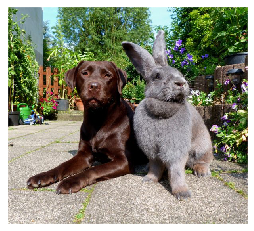

In [32]:
import matplotlib.image as mpimg
img = mpimg.imread('cute_flemish.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 9!")
plt.show()